In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FixedLocator

from astropy import constants as const
import astropy.units as u

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, Matern, ConstantKernel, RBF

In [2]:
%matplotlib notebook

In [3]:
# meta data
z = 0.0094
tb_max = 58863.34
t_fl = -17.4928
mu = 33.14
dist = 42.5

# Bolometric Luminosity

We will estimate the bolometric luminosity by integrating the SED (using trapezoidal integration). The optical observations will be interpolated to the times of UV observations, which are far less frequent.

In [4]:
flux_obs = pd.read_csv('../plots/flux_obs_19yvq.csv')
flux_obs.head(5)

,t_restframe,flux_Jy,flux_unc_Jy,filt
0,0.779844,0.000505,0.000007,r
1,0.847793,0.000374,0.000005,i
2,0.867332,0.000595,0.000006,g
3,3.731084,0.000488,0.000008,r
4,3.789436,0.000379,0.000006,g


In [5]:
swift_obs = np.where((flux_obs.filt == 'UVW1') | 
                     (flux_obs.filt == 'UVM2') | 
                     (flux_obs.filt == 'UVW2') )

In [6]:
this_epoch = flux_obs.t_restframe.values[438]
this_uvm2 = flux_obs.flux_Jy.iloc[np.where(flux_obs.t_restframe == this_epoch)].values[0]
this_uvw1 = flux_obs.flux_Jy.iloc[np.where((np.abs(flux_obs.t_restframe - this_epoch) < 0.04) & 
                                           (flux_obs.filt == 'UVW1'))].values[0]


In [7]:
uvm2_lambda_eff = 2360
uvw1_lambda_eff = 3050
g_lambda_eff = 4722.74
r_lambda_eff = 6339.61
i_lambda_eff = 7886.13

In [8]:
nu_eff = const.c.to('Angstrom/s').value/np.array([1000,
                                                  uvm2_lambda_eff, 
                                                  uvw1_lambda_eff, 
                                                  g_lambda_eff, 
                                                  r_lambda_eff, 
                                                  i_lambda_eff, 
                                                  21590])

In [9]:
g_obs = np.where(flux_obs.filt == 'g')
r_obs = np.where(flux_obs.filt == 'r')
i_obs = np.where(flux_obs.filt == 'i')

uvw1_obs = np.where(flux_obs.filt == 'UVW1')
uvm2_obs = np.where(flux_obs.filt == 'UVM2')

X_uvm2 = np.atleast_2d(flux_obs.iloc[uvm2_obs].t_restframe).T
y_uvm2 = flux_obs.iloc[uvm2_obs].flux_Jy


X_uvw1 = np.atleast_2d(flux_obs.iloc[uvw1_obs].t_restframe).T
y_uvw1 = flux_obs.iloc[uvw1_obs].flux_Jy

X_g = np.atleast_2d(flux_obs.iloc[g_obs].t_restframe).T
y_g = flux_obs.iloc[g_obs].flux_Jy

X_r = np.atleast_2d(flux_obs.iloc[r_obs].t_restframe).T
y_r = flux_obs.iloc[r_obs].flux_Jy

X_i = np.atleast_2d(flux_obs.iloc[i_obs].t_restframe).T
y_i = flux_obs.iloc[i_obs].flux_Jy


kernel = ConstantKernel(1)*Matern(length_scale=25, length_scale_bounds=(1e-2,100)) 

gpr_uvm2 = GaussianProcessRegressor(kernel=kernel, 
                                    alpha=flux_obs.iloc[uvm2_obs].flux_unc_Jy.values**2, 
                                    n_restarts_optimizer=9).fit(X_uvm2, y_uvm2)

gpr_uvw1 = GaussianProcessRegressor(kernel=kernel, 
                                    alpha=flux_obs.iloc[uvw1_obs].flux_unc_Jy.values**2, 
                                    n_restarts_optimizer=9).fit(X_uvw1, y_uvw1)


gpr_g = GaussianProcessRegressor(kernel=kernel, 
                                 alpha=flux_obs.iloc[g_obs].flux_unc_Jy.values**2, 
                                 n_restarts_optimizer=9).fit(X_g, y_g)

gpr_r = GaussianProcessRegressor(kernel=kernel,
                                 alpha=flux_obs.iloc[r_obs].flux_unc_Jy.values**2, 
                                 n_restarts_optimizer=9).fit(X_r, y_r)


gpr_i = GaussianProcessRegressor(kernel=kernel,
                                 alpha=flux_obs.iloc[i_obs].flux_unc_Jy.values**2, 
                                 n_restarts_optimizer=9).fit(X_i, y_i)


In [10]:
# K band to i band relative flux at 8500 K
temp = u.Kelvin*8500

i_bb = 1/(u.Angstrom*7886.13)**3*(1/(np.exp(const.h*const.c/(const.k_B*temp*(u.Angstrom*7886.13))) - 1))
J_bb = 1/(u.Angstrom*12350)**3*(1/(np.exp(const.h*const.c/(const.k_B*temp*(u.Angstrom*12350))) - 1))
H_bb = 1/(u.Angstrom*16620)**3*(1/(np.exp(const.h*const.c/(const.k_B*temp*(u.Angstrom*16620))) - 1))
K_bb = 1/(u.Angstrom*21590)**3*(1/(np.exp(const.h*const.c/(const.k_B*temp*(u.Angstrom*21590))) - 1))
bb_10 = 1/(u.Angstrom*100000)**3*(1/(np.exp(const.h*const.c/(const.k_B*temp*(u.Angstrom*100000))) - 1))

print(K_bb/i_bb)

full_curve = 1/(u.Angstrom*np.linspace(1e7,1e3,10000))**3*(1/(np.exp(const.h*const.c/(const.k_B*temp*(u.Angstrom*np.linspace(1e7,1e3,10000)))) - 1))

temp = u.Kelvin*12500
uvm2_bb = 1/(u.Angstrom*2360)**3*(1/(np.exp(const.h*const.c/(const.k_B*temp*(u.Angstrom*2360))) - 1))
bb_1000 = 1/(u.Angstrom*1000)**3*(1/(np.exp(const.h*const.c/(const.k_B*temp*(u.Angstrom*1000))) - 1))

print(bb_1000/uvm2_bb)

0.30929811261165874
0.017168826141433047


In [11]:
t_grid = np.linspace(0,45,1351)

obs_sed = np.array([gpr_uvm2.predict(np.atleast_2d(t_grid).T)*bb_1000/uvm2_bb,
                    gpr_uvm2.predict(np.atleast_2d(t_grid).T),
                    gpr_uvw1.predict(np.atleast_2d(t_grid).T),
                    gpr_g.predict(np.atleast_2d(t_grid).T), 
                    gpr_r.predict(np.atleast_2d(t_grid).T), 
                    gpr_i.predict(np.atleast_2d(t_grid).T),
                    gpr_i.predict(np.atleast_2d(t_grid).T)*K_bb/i_bb])

red_correction = 10**(0.4*np.array([0.4043,0.4043, 0.2745, 0.1877, 0.1240, 0.0876, 
                                    0.0876]))
true_sed = obs_sed.T*red_correction

In [12]:
flux2lum = 1e-23*4*np.pi*(42.5e6*const.pc.to('cm').value)**2

lum = np.trapz(np.flip(true_sed, axis=1), nu_eff[::-1]*(1+z)) * flux2lum

In [13]:
uvm2_pred, uvm2_unc = gpr_uvm2.predict(np.atleast_2d(t_grid).T, return_std=True)
uvw1_pred, uvw1_unc = gpr_uvw1.predict(np.atleast_2d(t_grid).T, return_std=True)
g_pred, g_unc = gpr_g.predict(np.atleast_2d(t_grid).T, return_std=True) 
r_pred, r_unc = gpr_r.predict(np.atleast_2d(t_grid).T, return_std=True) 
i_pred, i_unc = gpr_i.predict(np.atleast_2d(t_grid).T, return_std=True)

In [14]:
lum_unc = np.zeros((len(lum), 2))
for idx in range(len(lum)):
    uvm2_rand = np.random.normal(uvm2_pred[idx], uvm2_unc[idx], size=1000)
    uvw1_rand = np.random.normal(uvw1_pred[idx], uvw1_unc[idx], size=1000)
    g_rand = np.random.normal(g_pred[idx], g_unc[idx], size=1000)
    r_rand = np.random.normal(r_pred[idx], r_unc[idx], size=1000)
    i_rand = np.random.normal(i_pred[idx], i_unc[idx], size=1000)
    
    uvm2_rand = np.clip(uvm2_rand, 0, 1e10)
    uvw1_rand = np.clip(uvw1_rand, 0, 1e10)
    
    rand_sed = np.vstack([uvm2_rand*bb_1000.value/uvm2_bb.value, 
                      uvm2_rand, uvw1_rand, g_rand, r_rand, i_rand, 
                      i_rand*K_bb.value/i_bb.value]).T
    
    lum_unc[idx] = np.percentile(np.trapz(np.flip(rand_sed*red_correction, axis=1), 
                                          nu_eff[::-1]*(1+z)) * flux2lum, (16,84))

In [15]:
yunc = np.abs((lum_unc - lum[:,np.newaxis]).T)

<IPython.core.display.Javascript object>


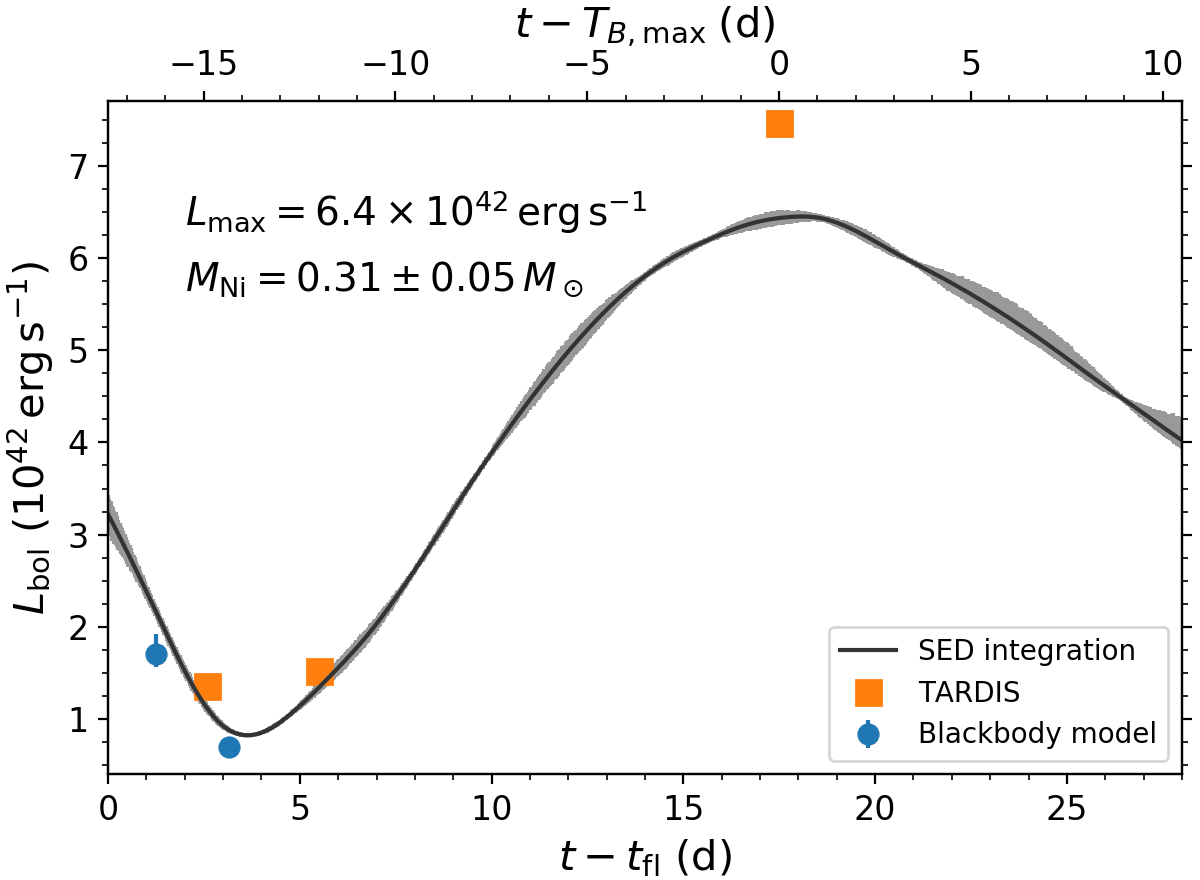

In [16]:
fig, ax = plt.subplots(figsize=(6,4.4))

ax.plot(t_grid, lum/1e42, '0.2', 
        zorder=10, label=r'SED integration')
ax.errorbar(t_grid, lum/1e42, yerr=yunc/1e42, color='0.6')

# blackbody fits
sol_conv = const.L_sun.to('erg/s').value/1e42
ax.errorbar([1.24, 3.15], 
            np.array([4.459e+08, 1.822e+08])*sol_conv,
            yerr = sol_conv*np.array([[3.674e+07, 1.554e+07],[5.662e+07,2.262e+07]]),
            fmt = 'o', ms=7, label = 'Blackbody model')

# TARDIS models
ax.plot(np.array([-14.9, -12.0, 0])-t_fl,
        sol_conv*10**np.array([8.55, 8.6, 9.29]), 
        's', ms=9, label='TARDIS')

ax.legend(loc=4)

ax.set_xlim(0,28)
ax.tick_params(right=True,which='both',labelsize=12)
ax.yaxis.set_minor_locator(MultipleLocator(0.25))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.set_ylim(0.4,7.7)

ax.set_ylabel(r'$L_\mathrm{bol}\,\,(10^{42}\,\mathrm{erg\,s}^{-1})$', fontsize=15)
ax.set_xlabel(r'$t - t_\mathrm{fl}$ (d)', fontsize=15)

ax.text(2, 6.35, r'$L_\mathrm{max} = 6.4 \times 10^{42}\,\mathrm{erg\,s}^{-1}$', fontsize=14)
ax.text(2, 5.65, r'$M_\mathrm{Ni} = 0.31 \pm 0.05\,M_\odot$', fontsize=14)


# set up time relative to T_Bmax
ax2 = ax.twiny()
ax2.set_xlabel(r"$t - T_{B,\mathrm{max}} \; (\mathrm{d})$", fontsize=15)
ax2.set_xlim(np.array(ax.get_xlim()) + t_fl)
ax2.tick_params(which='both', top=True, labelsize=12)
ax2.xaxis.set_minor_locator(MultipleLocator(1))


fig.subplots_adjust(top=0.885,right=0.985,left=0.09,bottom=0.12)
fig.savefig('../paper/figures/L_bolometric.pdf')

In [17]:
t_max = t_grid[np.argmax(lum)]
l_max = np.max(lum)
print(t_max, l_max, lum_unc[np.argmax(lum)])

18.1 6.449678584920211e+42 [6.39653807e+42 6.50858099e+42]


In [18]:
t_max = 18.1
nady = 6.45e43*np.exp(-t_max/8.8) + 1.45e43*np.exp(-t_max/111.3)
l_max/nady

0.31353729171848105